In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers, models
from PIL import Image
from tensorflow import lite



import cv2
import os
import pandas as pd

In [2]:
df = pd.read_csv('log.csv')

In [3]:
df.loc[df['Accelerate'] < 20, 'Accelerate'] = 0

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.image as mpimg
from imgaug import augmenters as iaa

import random


#### STEP 1 - INITIALIZE DATA
def getName(filePath):
    myImagePathL = filePath.split('/')[-2:]
    myImagePath = os.path.join(myImagePathL[0],myImagePathL[1])
    return myImagePath

def importDataInfo(path):
    columns = ['Center','Steering']
    noOfFolders = len(os.listdir(path))//2
    data = pd.DataFrame()
    for x in range(17,22):
        dataNew = pd.read_csv(os.path.join(path, f'log_{x}.csv'), names = columns)
        print(f'{x}:{dataNew.shape[0]} ',end='')
        #### REMOVE FILE PATH AND GET ONLY FILE NAME
        #print(getName(data['center'][0]))
        dataNew['Center']=dataNew['Center'].apply(getName)
        data =data.append(dataNew,True )
    print(' ')
    print('Total Images Imported',data.shape[0])
    return data

#### STEP 2 - VISUALIZE AND BALANCE DATA
def balanceData(data,display=True):
    nBin = 31
    samplesPerBin =  300
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.03)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.title('Data Visualisation')
        plt.xlabel('Steering Angle')
        plt.ylabel('No of Samples')
        plt.show()
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist, width=0.03)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.title('Balanced Data')
        plt.xlabel('Steering Angle')
        plt.ylabel('No of Samples')
        plt.show()
    return data

#### STEP 3 - PREPARE FOR PROCESSING
def loadData(path, data):
  imagesPath = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    imagesPath.append( os.path.join(path,indexed_data[0]))
    steering.append(float(indexed_data[1]))
  imagesPath = np.asarray(imagesPath)
  steering = np.asarray(steering)
  return imagesPath, steering


#### STEP 5 - AUGMENT DATA
def augmentImage(imgPath,steering):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.5, 1.2))
        img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
    return img, steering

# imgRe,st = augmentImage('DataCollected/IMG18/Image_1601839810289305.jpg',0)
# #mpimg.imsave('Result.jpg',imgRe)
# plt.imshow(imgRe)
# plt.show()

#### STEP 6 - PREPROCESS
def preProcess(img):
    # img = img[54:120,:,:]
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = img[54:120, :]
    
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

# imgRe = preProcess(mpimg.imread('DataCollected/IMG18/Image_1601839810289305.jpg'))
# # mpimg.imsave('Result.jpg',imgRe)
# plt.imshow(imgRe)
# plt.show()

#### STEP 7 - CREATE MODEL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def createModel():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(66, 200, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(Adam(learning_rate=0.0001),loss='mse', metrics=['mse'])
    return model

#### STEP 8 - TRAINNING
def dataGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            img = preProcess(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
        yield (np.asarray(imgBatch),np.asarray(steeringBatch))


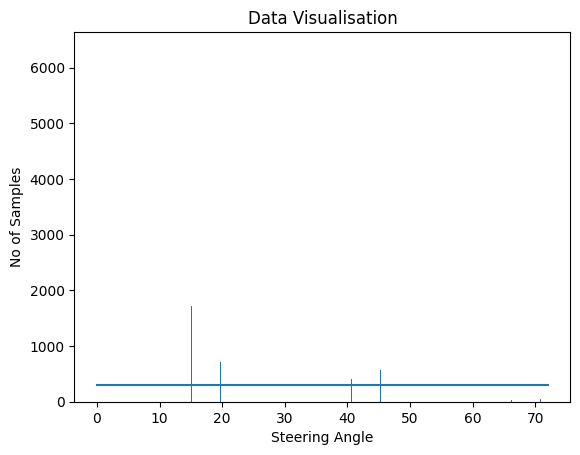

Removed Images: 15406
Remaining Images: 7097


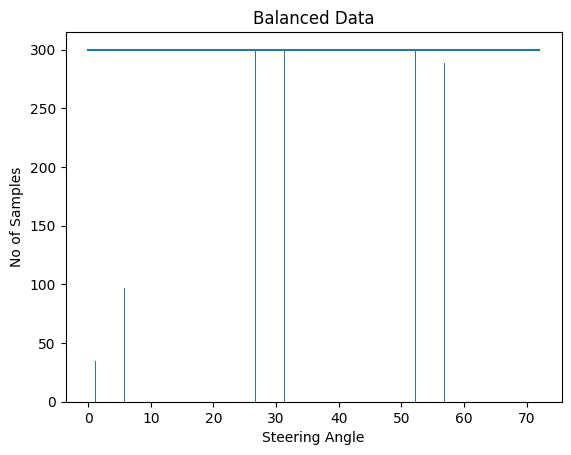

C:\Users\moustapha\AppData\Local\Temp\ipykernel_7092\1812113239.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imagesPath.append( os.path.join(path,indexed_data[0]))
C:\Users\moustapha\AppData\Local\Temp\ipykernel_7092\1812113239.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[1]))


Total Training Images:  5677
Total Validation Images:  1420


In [6]:
data = balanceData(df, display=True)
imagesPath, steerings = loadData('./', data)
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings,test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))


In [22]:
model = createModel()

history = model.fit(dataGen(xTrain, yTrain, 100, 1),
                                  steps_per_epoch=100,
                                  epochs=10,
                                  validation_data=dataGen(xVal, yVal, 50, 0),
                                  validation_steps=50)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 715ms/step - accuracy: 2.4550e-04 - loss: 1295.8732 - val_accuracy: 0.0000e+00 - val_loss: 1259.2616
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 670ms/step - accuracy: 1.1657e-04 - loss: 1104.5842 - val_accuracy: 0.0000e+00 - val_loss: 1012.2899
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 656ms/step - accuracy: 4.3612e-04 - loss: 1047.5900 - val_accuracy: 0.0000e+00 - val_loss: 1269.3904
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 690ms/step - accuracy: 4.1999e-04 - loss: 1022.0875 - val_accuracy: 0.0000e+00 - val_loss: 882.3651
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 647ms/step - accuracy: 3.9539e-04 - loss: 953.1058 - val_accuracy: 0.0000e+00 - val_loss: 687.7025
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 630ms/step - accuracy: 3.2100e-04 - loss: 958.2380 - val_accuracy: 0.0000e+00 - val_loss: 833.9009
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 644ms/step - accuracy: 1.5487e-04 - loss: 920.6875 - val_accuracy: 0.0000e+00 - val_loss: 7

In [23]:
model.save(f'voiture_autonome2.keras')
converter = lite.TFLiteConverter.from_keras_model(model)
tflitemodel = converter.convert()

with open('voiture_autonome2.tflite', 'wb') as f:
    f.write(tflitemodel)

print("Model saved")

INFO:tensorflow:Assets written to: C:\Users\MOUSTA~2\AppData\Local\Temp\tmp_wvbm4oq\assets


INFO:tensorflow:Assets written to: C:\Users\MOUSTA~2\AppData\Local\Temp\tmp_wvbm4oq\assets


Saved artifact at 'C:\Users\MOUSTA~2\AppData\Local\Temp\tmp_wvbm4oq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 66, 200, 1), dtype=tf.float32, name='keras_tensor_36')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2030013286000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030013285120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030729867856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2030729868384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031288780048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031288780224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031288778992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031288779872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031289246992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031289246640: TensorSpec(shape=(), dtype=tf.resource, name=None)
Mo

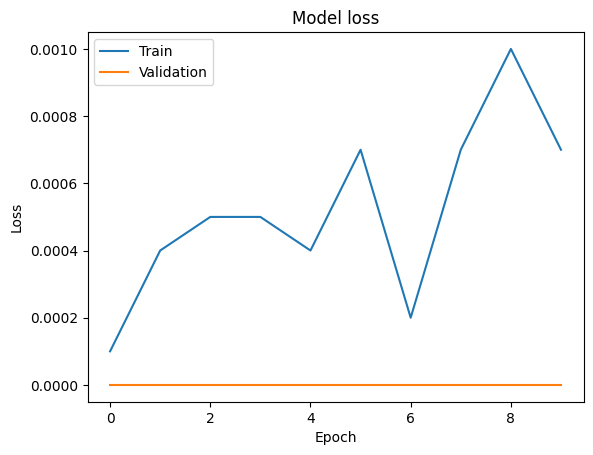

In [28]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
history.history

{'accuracy': [9.999999747378752e-05,
  0.00039999998989515007,
  0.0005000000237487257,
  0.0005000000237487257,
  0.00039999998989515007,
  0.000699999975040555,
  0.00019999999494757503,
  0.000699999975040555,
  0.0010000000474974513,
  0.000699999975040555],
 'loss': [1220.2098388671875,
  1094.0882568359375,
  1035.506103515625,
  1008.9202270507812,
  955.0797729492188,
  947.8165283203125,
  916.1273803710938,
  883.08251953125,
  871.6317138671875,
  842.365478515625],
 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'val_loss': [1259.2615966796875,
  1012.2899169921875,
  1269.390380859375,
  882.3651123046875,
  687.7025146484375,
  833.90087890625,
  716.634521484375,
  903.4204711914062,
  918.5219116210938,
  683.45556640625]}